# Initial EDA

In [681]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import json
import gzip
import os
import random
import string
from collections import defaultdict
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import warnings 
warnings.filterwarnings('ignore')

random.seed(42) # seeding for rerunning purposes

In [3]:
# Monday 
# TODO: scale process to get review data for 1000 books for each pre defined genre
# TODO: Initial Clusters 

In [166]:
def load_data_fuzzy(file_name, head = 999999):
    count = 0
    data = []
    with gzip.open(file_name) as fin:

        for l in fin:
            d = json.loads(l)
            if d['book_id'] in book_ids:
                count += 1
                data.append(d)

            # break point > head
            if (head is not None) and (count > head):
                break
    return data 

def load_data_interactions(file_name, head = 9999):
    count = 0
    data = []
    with gzip.open(file_name) as fin:

        for l in fin:
            d = json.loads(l)
            if d['is_read']:
                count += 1
                data.append(d['book_id'])
            
            # break point > head
            if (head is not None) and (count > head):
                break
    return data 

def load_data_read(file_name, head = 999):
    count = 0
    data = []
    with gzip.open(file_name) as fin:

        for l in fin:
            d = json.loads(l)
            if d['book_id'] in read_list:
                count += 1
                data.append(d)
            
            # break point > head
            if (head is not None) and (count > head):
                break
    return data 


def load_data_reviews(file_name, head = 999999):
    count = 0
    data = []
    with gzip.open(file_name) as fin:

        for l in fin:
            d = json.loads(l)
            count += 1
            
            dic = {}
            dic['book_id'] = d['book_id']
            dic['review_text'] = d['review_text']
            
            data.append(dic)
            
            # break point > head
            if (head is not None) and (count > head):
                break
    return data 

def combine_data(root, what):
    assert type(what) is int, 'MUST BE INT'
    predefined_genres = os.listdir(root)
    
    if what == 1:
        data_agg = []
        for genre in predefined_genres:
            is_read = load_data_interactions(os.path.join(root, genre))
            # selected_books = random.sample(raw_data, 1000) # sample 1000 without replacement, list 
            data_agg.append(is_read)
            
        
        final_book_data = [book for selected_books in data_agg for book in selected_books]
        return pd.DataFrame(final_book_data)
    
    if what == 2: 
        data_agg = []
        for genre in predefined_genres:
            print(genre)
            if genre != '.DS_Store':
                read_data = load_data_read(os.path.join(root, genre))
                data_agg.append(read_data)
            else:
                continue
            
        final_book_data = [book for selected_books in data_agg for book in selected_books]
        return pd.DataFrame(final_book_data)
    
    if what == 3: 
        data_agg = []
        for genre in predefined_genres:
            print(genre)
            if genre != '.DS_Store':
                read_data = load_data_reviews(os.path.join(root, genre))
                data_agg.append(read_data)
            else:
                continue
            
        final_book_data = [book for selected_books in data_agg for book in selected_books]
        return pd.DataFrame(final_book_data)

In [5]:
inter = r'/Users/michaelfronda/Desktop/Main/OMSA/22-FA-ISYE6740/data-interactions'
is_read = combine_data(inter, what=1) 

In [6]:
read_list = list(is_read[0])

In [7]:
graphs = r'/Users/michaelfronda/Desktop/Main/OMSA/22-FA-ISYE6740/data-book-graphs'
book_data = combine_data(graphs, what=2)
# LONG RUN 

goodreads_books_comics_graphic.json.gz
goodreads_books_children.json.gz
.DS_Store
goodreads_books_fantasy_paranormal.json.gz
goodreads_books_young_adult.json.gz
goodreads_books_history_biography.json.gz
goodreads_books_romance.json.gz
goodreads_books_mystery_thriller_crime.json.gz
goodreads_books_poetry.json.gz


In [8]:
revs = r'/Users/michaelfronda/Desktop/Main/OMSA/22-FA-ISYE6740/data-reviews'
reviews = combine_data(revs, what=3)
# LONG RUN

goodreads_reviews_mystery_thriller_crime.json.gz
goodreads_reviews_poetry.json.gz
goodreads_reviews_children.json.gz
goodreads_reviews_romance.json.gz
goodreads_reviews_history_biography.json.gz
goodreads_reviews_fantasy_paranormal.json.gz
goodreads_reviews_young_adult.json.gz
goodreads_reviews_comics_graphic.json.gz


In [9]:
reviews

,book_id,review_text
0,6392944,I haven't read a fun mystery book in a while a...
1,28684704,"A fun, fast paced science fiction thriller. I ..."
2,32283133,http://www.telegraph.co.uk/culture/10...
3,17860739,An amazing and unique creation: JJ Abrams and ...
4,8694005,The Name of the Rose is a thrilling Dan Brown-...
...,...,...
6431528,20176586,Bumping this up to a three star rating primari...
6431529,11465282,The story didn't pull me in although I'm aware...
6431530,31094296,Stunning follow up. Once again it's not the ar...
6431531,27404461,I grew up with the Terran Trade Authority book...


In [10]:
combined = pd.merge(book_data, reviews, how='left', on=['book_id'])

In [11]:
combined['book_id_str'] = combined['book_id'].map(str)
combined['review_text'] = combined['review_text'].map(str)

In [12]:
combined['combined_review'] = combined[['book_id','review_text']].groupby(['book_id'])['review_text'].transform(lambda x: '\t'.join(x))

In [13]:
concatenated_review = combined[['book_id','combined_review']].drop_duplicates()
# LONG RUN 

In [14]:
final_df = pd.merge(book_data, concatenated_review, how='inner', on=['book_id'])

In [15]:
final_df

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series,combined_review
0,0785165037,71,"[520884, 678696]",US,eng,"[{'count': '211', 'name': 'to-read'}, {'count'...",,false,4.10,B00PSN2IHM,...,,2013,https://www.goodreads.com/book/show/17277795-u...,https://images.gr-assets.com/books/1377214930m...,17277795,651,23891166,"Ultimate Comics: Spider-Man, by Brian Michael ...","Ultimate Comics: Spider-Man, by Brian Michael ...",Why does everything always have to be so damn ...
1,1595825010,192,[],US,en-US,"[{'count': '1433', 'name': 'to-read'}, {'count...",,false,4.03,B00A820UFU,...,First Edition,2010,https://www.goodreads.com/book/show/7961571-th...,https://images.gr-assets.com/books/1403206833m...,7961571,2663,9929356,The Amazing Screw-on Head and Other Curious Ob...,The Amazing Screw-on Head and Other Curious Ob...,Stories in the Mignola style and visuals. As a...
2,,1,"[194208, 1114845, 1124201]",US,eng,"[{'count': '322', 'name': 'to-read'}, {'count'...",,false,3.88,,...,ISBN 1563898012 alternate cover,2002,https://www.goodreads.com/book/show/13423869-b...,https://s.gr-assets.com/assets/nophoto/book/11...,13423869,2,103212,Batman/Huntress: Cry for Blood,Batman/Huntress: Cry for Blood,"A retelling of her origin, slightly updated fr..."
3,0785128816,51,[397476],US,eng,"[{'count': '228', 'name': 'to-read'}, {'count'...",,false,3.30,B00AAJR090,...,Premiere,2008,https://www.goodreads.com/book/show/5626060-hu...,https://s.gr-assets.com/assets/nophoto/book/11...,5626060,602,5797459,"Hulk, Volume 1: Red Hulk","Hulk, Volume 1: Red Hulk",Loeb takes a great mystery and turns it in a l...
4,0316358452,125,[199703],US,eng,"[{'count': '407', 'name': 'comics'}, {'count':...",,false,4.17,,...,American Edition,1976,https://www.goodreads.com/book/show/179172.Des...,https://images.gr-assets.com/books/1344265829m...,179172,7997,2278369,"Destination Moon (Tintin, #16)","Destination Moon (Tintin, #16)",The first part of Herge's two part 'Trip to th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0571176550,99,[],US,eng,"[{'count': '2480', 'name': 'to-read'}, {'count...",,false,4.15,,...,Faber Library Edition,1996,https://www.goodreads.com/book/show/97553.Crow,https://images.gr-assets.com/books/1468984529m...,97553,1983,94172,Crow: From the Life and Songs of the Crow,Crow: From the Life and Songs of the Crow,"What a horrible lil' dreamscape. Seriously, th..."
7996,,51,[],US,ara,"[{'count': '264', 'name': 'to-read'}, {'count'...",,true,3.40,,...,manuscript,2014,https://www.goodreads.com/book/show/20878228,https://images.gr-assets.com/books/1398243693m...,20878228,146,40218004,الحب جالس في مقهى الماضي,الحب جالس في مقهى الماضي,akhr m Sdr l swzn `lywn \n jmyl@ k `dth .. wn ...
7997,0003027600,49,[],US,per,"[{'count': '349', 'name': 'to-read'}, {'count'...",,false,4.55,,...,,,https://www.goodreads.com/book/show/230246._,https://s.gr-assets.com/assets/nophoto/book/11...,230246,1394,222980,دیوان كلیات شمس تبریزی,دیوان كلیات شمس تبریزی,"very good\tBrilliant!if you want to know how ""..."
7998,0385244843,5,[],US,eng,"[{'count': '546', 'name': 'to-read'}, {'count'...",,false,4.31,,...,,1989,https://www.goodreads.com/book/show/286114.Hai...,https://images.gr-assets.com/books/1320507426m...,286114,31,11442,Hailstones and Halibut Bones,Hailstones and Halibut Bones,I purchased this for the light and colors unit...


In [130]:
deduped_df = final_df.drop_duplicates(subset="title", keep='first')
deduped_df

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series,combined_review
0,0785165037,71,"[520884, 678696]",US,eng,"[{'count': '211', 'name': 'to-read'}, {'count'...",,false,4.10,B00PSN2IHM,...,,2013,https://www.goodreads.com/book/show/17277795-u...,https://images.gr-assets.com/books/1377214930m...,17277795,651,23891166,"Ultimate Comics: Spider-Man, by Brian Michael ...","Ultimate Comics: Spider-Man, by Brian Michael ...",Why does everything always have to be so damn ...
1,1595825010,192,[],US,en-US,"[{'count': '1433', 'name': 'to-read'}, {'count...",,false,4.03,B00A820UFU,...,First Edition,2010,https://www.goodreads.com/book/show/7961571-th...,https://images.gr-assets.com/books/1403206833m...,7961571,2663,9929356,The Amazing Screw-on Head and Other Curious Ob...,The Amazing Screw-on Head and Other Curious Ob...,Stories in the Mignola style and visuals. As a...
2,,1,"[194208, 1114845, 1124201]",US,eng,"[{'count': '322', 'name': 'to-read'}, {'count'...",,false,3.88,,...,ISBN 1563898012 alternate cover,2002,https://www.goodreads.com/book/show/13423869-b...,https://s.gr-assets.com/assets/nophoto/book/11...,13423869,2,103212,Batman/Huntress: Cry for Blood,Batman/Huntress: Cry for Blood,"A retelling of her origin, slightly updated fr..."
3,0785128816,51,[397476],US,eng,"[{'count': '228', 'name': 'to-read'}, {'count'...",,false,3.30,B00AAJR090,...,Premiere,2008,https://www.goodreads.com/book/show/5626060-hu...,https://s.gr-assets.com/assets/nophoto/book/11...,5626060,602,5797459,"Hulk, Volume 1: Red Hulk","Hulk, Volume 1: Red Hulk",Loeb takes a great mystery and turns it in a l...
4,0316358452,125,[199703],US,eng,"[{'count': '407', 'name': 'comics'}, {'count':...",,false,4.17,,...,American Edition,1976,https://www.goodreads.com/book/show/179172.Des...,https://images.gr-assets.com/books/1344265829m...,179172,7997,2278369,"Destination Moon (Tintin, #16)","Destination Moon (Tintin, #16)",The first part of Herge's two part 'Trip to th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7994,,5,[460639],US,eng,"[{'count': '27', 'name': 'to-read'}, {'count':...",,false,4.11,,...,,1958,https://www.goodreads.com/book/show/5961725-th...,https://images.gr-assets.com/books/1358181861m...,5961725,62,6134574,The Four Seasons (Japanese Haiku Series II),The Four Seasons (Japanese Haiku Series II),"Best enjoyed with a cup of coffee, a slow movi..."
7995,0571176550,99,[],US,eng,"[{'count': '2480', 'name': 'to-read'}, {'count...",,false,4.15,,...,Faber Library Edition,1996,https://www.goodreads.com/book/show/97553.Crow,https://images.gr-assets.com/books/1468984529m...,97553,1983,94172,Crow: From the Life and Songs of the Crow,Crow: From the Life and Songs of the Crow,"What a horrible lil' dreamscape. Seriously, th..."
7996,,51,[],US,ara,"[{'count': '264', 'name': 'to-read'}, {'count'...",,true,3.40,,...,manuscript,2014,https://www.goodreads.com/book/show/20878228,https://images.gr-assets.com/books/1398243693m...,20878228,146,40218004,الحب جالس في مقهى الماضي,الحب جالس في مقهى الماضي,akhr m Sdr l swzn `lywn \n jmyl@ k `dth .. wn ...
7997,0003027600,49,[],US,per,"[{'count': '349', 'name': 'to-read'}, {'count'...",,false,4.55,,...,,,https://www.goodreads.com/book/show/230246._,https://s.gr-assets.com/assets/nophoto/book/11...,230246,1394,222980,دیوان كلیات شمس تبریزی,دیوان كلیات شمس تبریزی,"very good\tBrilliant!if you want to know how ""..."


In [16]:
# Tuesday 
# TODO: Continue Clustering books, different methods?

In [144]:
deduped_df['combined_review'][2]

'A retelling of her origin, slightly updated from the Year One saga.'

In [132]:
counter = 0
for shelf in deduped_df['popular_shelves']:
    print(shelf[0])
    counter += 1 
    if counter == 3:
        break

{'count': '211', 'name': 'to-read'}
{'count': '1433', 'name': 'to-read'}
{'count': '322', 'name': 'to-read'}


In [133]:
d = defaultdict(int)
for shelf in deduped_df['popular_shelves']:
    for l in shelf:
        d[l['name']] += int(l['count'])

In [134]:
raw_dict_shelves = {k: v for k, v in sorted(dict(d).items(), key=lambda item: item[1], reverse=True)}

In [135]:
# keyval = defaultdict(int)
# tc = 0
# for i in final_df['popular_shelves'][47]:
#     tc += int(i['count'])
    
# for i in final_df['popular_shelves'][47]:
#     ratio = int(i['count']) / tc
#     print(ratio)
#     if ratio < 0.25 and ratio > float(25)/len(final_df['popular_shelves'][47]):
#         keyval[i['name']] += int(i['count'])
        

In [136]:
valid_chars = set(string.printable)
min_count_shelfs = 30

trimmed_shelves = {}
for k,v in raw_dict_shelves.items():
    if v >= min_count_shelfs and all(letter in valid_chars for letter in k): 
        trimmed_shelves[k] = v

In [137]:
len(raw_dict_shelves)

88237

In [138]:
len(trimmed_shelves)

6531

In [139]:
list_dic = []
for book_shelves in deduped_df['popular_shelves']:
    d = defaultdict(int)
    for shelf in book_shelves:
        if shelf['name'] in list(trimmed_shelves.keys()):
            d[shelf['name']] += int(shelf['count'])
    list_dic.append(dict(d))

In [114]:
dictvectorizer = DictVectorizer(sparse=False)
raw_sparse_shelfs = dictvectorizer.fit_transform(list_dic)
columns = dictvectorizer.get_feature_names()

In [140]:
raw_sparse_shelfs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 3., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

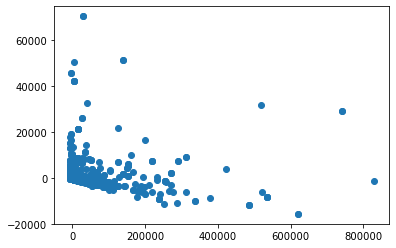

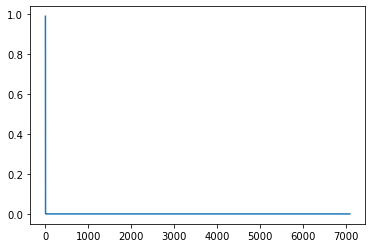

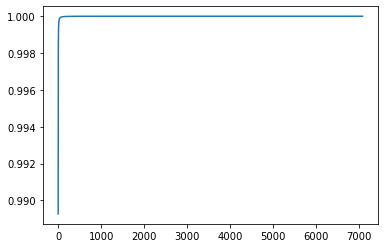

In [142]:
# INCONCLUSIVE # 
# pca 
pca = PCA()
reduction = pca.fit_transform(raw_sparse_shelfs)
plt.scatter(reduction[:,0], reduction[:,1])
plt.show()

plt.plot(pca.explained_variance_ratio_)
plt.show()

# cumulative variance
# choose k = number of dimensions that gives us 95-99% variance
cumulative = []
last = 0
for v in pca.explained_variance_ratio_:
    cumulative.append(last + v)
    last = cumulative[-1]
plt.plot(cumulative)
plt.show()

In [165]:
# 
book_ids = list(deduped_df['book_id'])

In [167]:
root = r'/Users/michaelfronda/Desktop/Main/OMSA/22-FA-ISYE6740/data-general'
fuzzy_genres = pd.DataFrame(load_data_fuzzy(os.path.join(root, 'goodreads_book_genres_initial.json.gz')))

In [237]:
c = 0
dd = defaultdict(int)
for row in fuzzy_genres['genres']:
    for k,v in row.items():
        dd[k] += v

defaultdict(int,
            {'mystery, thriller, crime': 700495,
             'fiction': 1722014,
             'history, historical fiction, biography': 606427,
             'fantasy, paranormal': 1935431,
             'children': 463965,
             'young-adult': 1216665,
             'poetry': 181589,
             'non-fiction': 202946,
             'comics, graphic': 574267,
             'romance': 676601})

In [238]:
len(dd.keys()) # 10 genres

10

In [177]:
fuzzy_genres

,book_id,genres
0,17368265,"{'mystery, thriller, crime': 854, 'fiction': 2..."
1,8030991,"{'children': 4, 'young-adult': 2}"
2,926662,"{'poetry': 10, 'children': 9, 'fiction': 1, 'n..."
3,7351310,"{'history, historical fiction, biography': 4, ..."
4,7843586,"{'romance': 232, 'fiction': 11, 'mystery, thri..."
...,...,...
6816,5961725,"{'poetry': 10, 'fiction': 1}"
6817,97553,"{'poetry': 590, 'fiction': 11}"
6818,20878228,{'poetry': 10}
6819,230246,"{'poetry': 7, 'history, historical fiction, bi..."


In [183]:
df_v2 = pd.merge(deduped_df, fuzzy_genres, how='inner', on=['book_id'])

In [275]:
genre_list = list(dict(dd).keys())
genre_list

['mystery, thriller, crime',
 'fiction',
 'history, historical fiction, biography',
 'fantasy, paranormal',
 'children',
 'young-adult',
 'poetry',
 'non-fiction',
 'comics, graphic',
 'romance']

In [262]:
df = df_v2.copy()

In [320]:
mystery = []
fiction = []
history = []
fantasy = []
child = []
ya = []
poetry = []
nonfic = []
comics = []
romance = []

max_genrel = []

# c = 0

for i,row in df.iterrows():
    mystery.append(0)
    fiction.append(0)
    history.append(0)
    fantasy.append(0)
    child.append(0)
    ya.append(0)
    poetry.append(0)
    nonfic.append(0)
    comics.append(0)
    romance.append(0)
    
    max_genre = max(row['genres'], key=row['genres'].get)
    max_genrel.append(max_genre)
    
    ks = row['genres'].keys()
    if 'mystery, thriller, crime' in ks:
        mystery[i] = row['genres']['mystery, thriller, crime']
    if 'fiction' in ks:
        fiction[i] = row['genres']['fiction']
    if 'history, historical fiction, biography' in ks:
        history[i] = row['genres']['history, historical fiction, biography']
    if 'comics, graphic' in ks:
        comics[i] = row['genres']['comics, graphic']
    if 'fantasy, paranormal' in ks:
        fantasy[i] = row['genres']['fantasy, paranormal']
    if 'children' in ks:
        child[i] = row['genres']['children']
    if 'young-adult' in ks:
        ya[i] = row['genres']['young-adult']
    if 'poetry' in ks:
        poetry[i] = row['genres']['poetry']
    if 'non-fiction' in ks:
        nonfic[i] = row['genres']['non-fiction']
    if 'comics, graphic' in ks:
        comics[i] = row['genres']['comics, graphic']
    if 'romance' in ks:
        romance[i] = row['genres']['romance']
        
        
        
        
#     for k,v in row['genres'].items():
#         if re.match(r"mystery.*", k):
#             mystery.append(v)
#         else:
#             mystery.append(0)
            
#         if re.match(r"fiction.*", k):
#             fiction.append(v)
#         else:
#             fiction.append(0)
            
#         if re.match(r"history.*", k):
#             history.append(v)
#         else:
#             history.append(0)
            
#         if re.match(r"fantasy.*", k):
#             fantasy.append(v)
#         else:
#             fantasy.append(0)
            
#         if re.match(r"child.*", k):
#             child.append(v)
#         else:
#             child.append(0)
            
#         if re.match(r"young-ad.*", k):
#             ya.append(v)
#         else:
#             ya.append(0)
            
#         if re.match(r"poet.*", k):
#             poetry.append(v)
#         else:
#             poetry.append(0)
            
#         if re.match(r"comic.*", k):
#             comics.append(v)
#         else:
#             comics.append(0)
            
#         if re.match(r"roman.*", k):
#             romance.append(v)
#         else:
#             romance.append(0)
    
#     c += 1
#     if c == 3:
#         break

In [341]:
df['max_genre'] = max_genrel
df['mystery'] = mystery
df['fiction'] = fiction
df['history'] = history
df['fantasy'] = fantasy
df['child'] = child
df['ya'] = ya
df['poetry'] = poetry
df['nonfic'] = nonfic
df['comics'] = comics
df['romance'] = romance

genre_list_n = {x:i for i,x in enumerate(genre_list)}

max_genren = max_genrel.copy()

for i,x in enumerate(max_genrel):
    max_genren[i] = genre_list_n[x]
    
df['max_genre_numeric'] = max_genren

# 0 mystery, thriller, crime
# 1 fiction
# 2 history, historical fiction, biography
# 3 fantasy, paranormal
# 4 children
# 5 young-adult
# 6 poetry
# 7 non-fiction
# 8 comics, graphic
# 9 romance

In [344]:
df.loc[0].T

isbn                                                           0785165037
text_reviews_count                                                     71
series                                                   [520884, 678696]
country_code                                                           US
language_code                                                         eng
popular_shelves         [{'count': '211', 'name': 'to-read'}, {'count'...
asin                                                                     
is_ebook                                                            false
average_rating                                                       4.10
kindle_asin                                                    B00PSN2IHM
similar_books           [13528706, 13276506, 17277786, 17182373, 84819...
description             The Daily Bugle is on the hunt to find out eve...
format                                                          Hardcover
link                    https://www.go

In [578]:
numeric_df = df[['average_rating', 'ratings_count', 
'mystery',                                                                 
'fiction',                                                                 
'history',                                                                 
'fantasy',                                                                 
'child',                                                                  
'ya',                                                                      
'poetry',                                                                  
'nonfic',                                                                  
'comics',                                                                
'romance',
'max_genre_numeric']]


In [579]:
numeric_df["average_rating"] = numeric_df["average_rating"].astype(float)
numeric_df["ratings_count"] = numeric_df["ratings_count"].astype(int)

In [580]:
numeric_df.describe()

,average_rating,ratings_count,mystery,fiction,history,fantasy,child,ya,poetry,nonfic,comics,romance,max_genre_numeric
count,6821.000000,6.821000e+03,6821.000000,6821.000000,6821.000000,6821.000000,6821.000000,6821.000000,6821.000000,6821.000000,6821.000000,6821.000000,6821.000000
mean,3.947698,1.042756e+04,102.696819,252.457704,88.905879,283.745932,68.020085,178.370474,26.622050,29.753115,84.191028,99.193813,4.615599
std,0.319616,7.686050e+04,631.619600,1165.078392,519.990924,1781.641653,491.569585,1180.579199,192.839603,257.798102,569.565241,412.577840,2.956778
min,1.760000,1.000000e+00,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,3.760000,2.060000e+02,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,3.970000,1.099000e+03,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,4.170000,5.152000e+03,10.000000,105.000000,3.000000,17.000000,0.000000,9.000000,0.000000,0.000000,0.000000,26.000000,8.000000
max,5.000000,4.899965e+06,18554.000000,26304.000000,18458.000000,54145.000000,15478.000000,30173.000000,3927.000000,8351.000000,15967.000000,10207.000000,9.000000


In [592]:
mask1 = (numeric_df['ratings_count'] > 25)
v = numeric_df[mask1]
numeric_v2 = v[v['ratings_count'] < 3000]
ready2scale = numeric_v2.loc[:, numeric_v2.columns != 'max_genre_numeric']

In [598]:
scaler = StandardScaler()
scaler.fit(ready2scale)
scaled = scaler.fit_transform(ready2scale)
scaled_df = pd.DataFrame(scaled, columns=ready2scale.columns)

In [599]:
scaled_df

,average_rating,ratings_count,mystery,fiction,history,fantasy,child,ya,poetry,nonfic,comics,romance
0,0.547446,-0.136386,-0.109690,-0.148233,-0.132046,-0.100023,-0.108319,-0.096910,-0.146197,-0.093591,0.653013,-0.165951
1,0.335725,2.478195,-0.109690,-0.120385,-0.127819,-0.071586,-0.108319,-0.098769,-0.146197,-0.093591,1.521128,-0.165951
2,-1.872229,-0.200061,-0.107985,-0.150844,-0.132046,-0.098908,-0.106133,-0.103418,-0.146197,-0.093591,0.370304,-0.165951
3,0.789414,0.040345,-0.106279,-0.150844,-0.132046,-0.090544,-0.108319,-0.101559,-0.146197,-0.093591,-0.086599,-0.155600
4,-1.539523,-0.771839,-0.106279,-0.146493,-0.096119,-0.100023,-0.108319,-0.103418,-0.146197,-0.093591,0.036194,-0.165951
...,...,...,...,...,...,...,...,...,...,...,...,...
4192,0.577692,-0.901788,-0.109690,-0.154325,-0.132046,-0.100023,-0.108319,-0.103418,-0.096891,-0.093591,-0.140856,-0.165951
4193,0.698676,1.594540,-0.109690,-0.145623,-0.132046,-0.100023,-0.108319,-0.103418,2.762859,-0.093591,-0.140856,-0.165951
4194,-1.569769,-0.792631,-0.109690,-0.155196,-0.132046,-0.100023,-0.108319,-0.103418,-0.096891,-0.093591,-0.140856,-0.165951
4195,1.908514,0.829138,-0.109690,-0.154325,-0.127819,-0.100023,-0.108319,-0.103418,-0.111683,-0.076907,-0.140856,-0.165951


In [600]:
# ['mystery',                                                                 
# 'fiction',                                                                 
# 'history',                                                                 
# 'fantasy',                                                                 
# 'child',                                                                  
# 'ya',                                                                      
# 'poetry',                                                                  
# 'nonfic',                                                                  
# 'comics',                                                                
# 'romance']                                                                 

In [601]:
 # filter out outliers

<AxesSubplot:xlabel='average_rating', ylabel='ratings_count'>

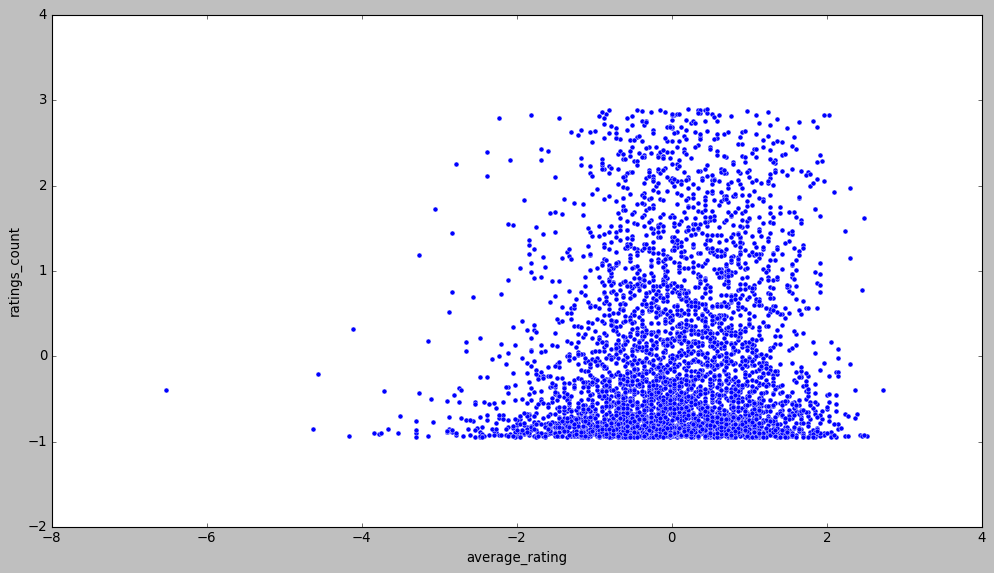

In [602]:
plt.figure(figsize =(15,8))
sns.scatterplot(x ='average_rating', y = 'ratings_count', data = scaled_df)

In [603]:
ratings = scaled_df[['average_rating', 'ratings_count']]

kmeans = KMeans(10)
kmeans.fit(ratings)
clusters = kmeans.fit_predict(ratings)

<AxesSubplot:xlabel='average_rating', ylabel='ratings_count'>

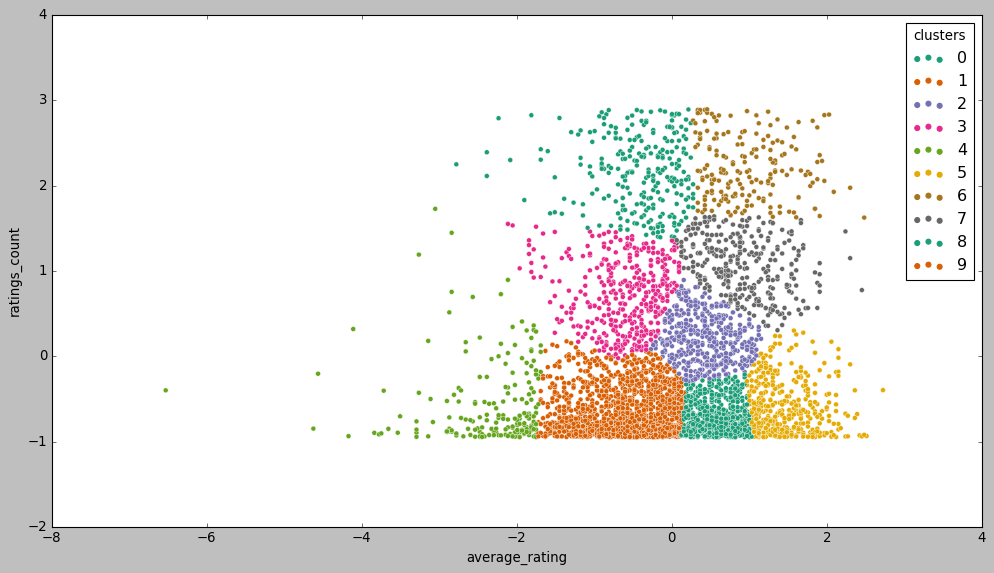

In [604]:
init_clusters = scaled_df.copy()
init_clusters['clusters'] = clusters 

plt.figure(figsize =(15,8))
sns.scatterplot(x ="average_rating", y = "ratings_count", data = init_clusters, hue = "clusters", palette = "Dark2" )
# inconclusive # 

In [605]:
# normalized_sparse_shelfs = [list(row / row.sum()) for row in raw_sparse_shelfs]

In [606]:
# mat = np.array(normalized_sparse_shelfs)

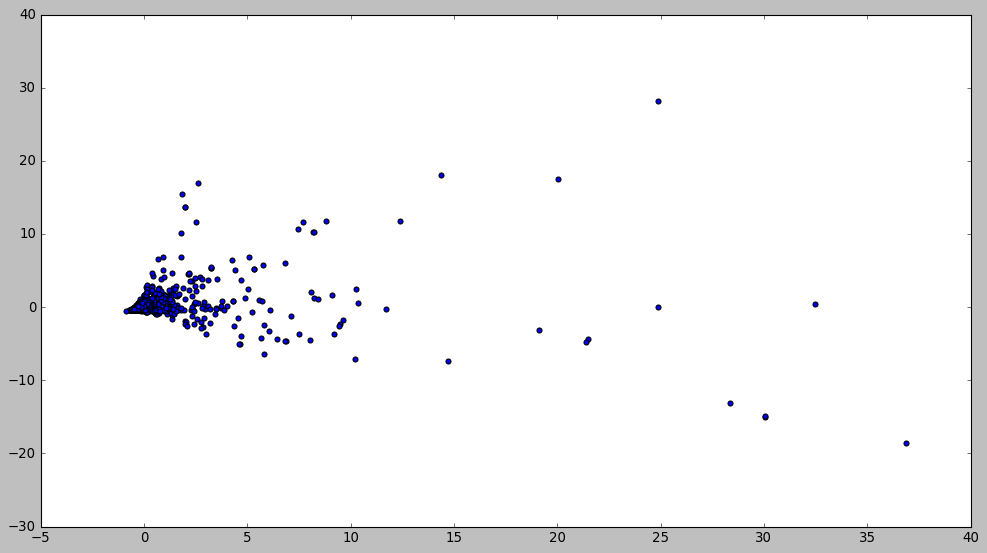

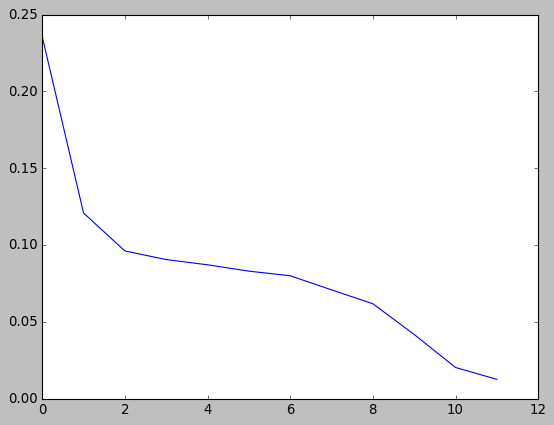

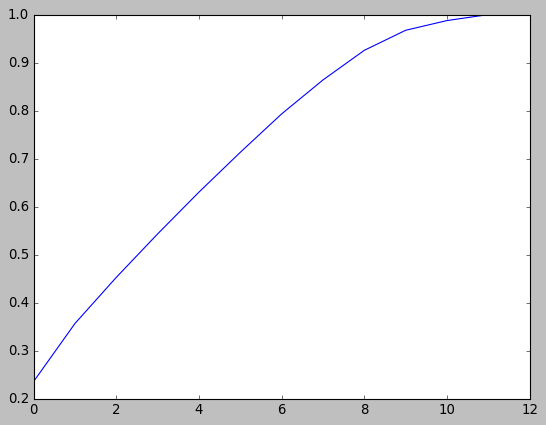

In [607]:
pca = PCA()
reduction = pca.fit_transform(scaled_df)
plt.figure(figsize =(15,8))
plt.scatter(reduction[:,0], reduction[:,1])
plt.show()

plt.plot(pca.explained_variance_ratio_)
plt.show()

# cumulative variance
# choose k = number of dimensions that gives us 95-99% variance
cumulative = []
last = 0
for v in pca.explained_variance_ratio_:
    cumulative.append(last + v)
    last = cumulative[-1]
plt.plot(cumulative)
plt.show()

In [608]:
tsne = TSNE(perplexity=40)
Z = tsne.fit_transform(scaled_df)

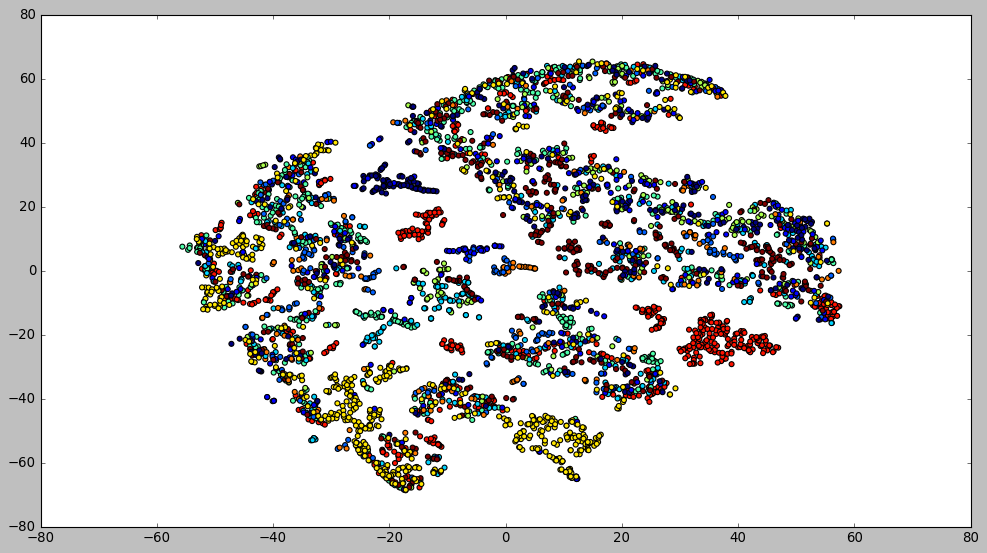

In [609]:
plt.figure(figsize =(15,8))
plt.scatter(Z[:,0], Z[:,1], c=numeric_v2['max_genre_numeric']);

In [611]:
# going to have match indices back up for numeric_v2

In [612]:
Z[:,:2]

array([[ -7.7896323, -23.380445 ],
       [ 44.78544  , -22.984026 ],
       [ 17.890522 ,  44.96992  ],
       ...,
       [ 12.142035 ,  61.956257 ],
       [ 20.362165 , -40.468224 ],
       [ 12.392114 , -48.12354  ]], dtype=float32)

In [613]:
kmeans = KMeans(20)
kmeans.fit(Z[:,:2])
clusters = kmeans.fit_predict(Z[:,:2])
# init_clusters = scaled_df.copy()
# init_clusters['clusters'] = clusters 

# plt.figure(figsize =(15,8))
# sns.scatterplot(x ="average_rating", y = "ratings_count", data = init_clusters, hue = "clusters", palette = "Dark2" )
# # inconclusive # 

In [614]:
clusters_v1 = pd.concat([pd.DataFrame(Z[:,:2]), pd.DataFrame(clusters)],axis = 1)
clusters_v1.set_axis(['comp_1', 'comp_2', 'clusters_10'], axis=1, inplace=True)

<AxesSubplot:xlabel='comp_1', ylabel='comp_2'>

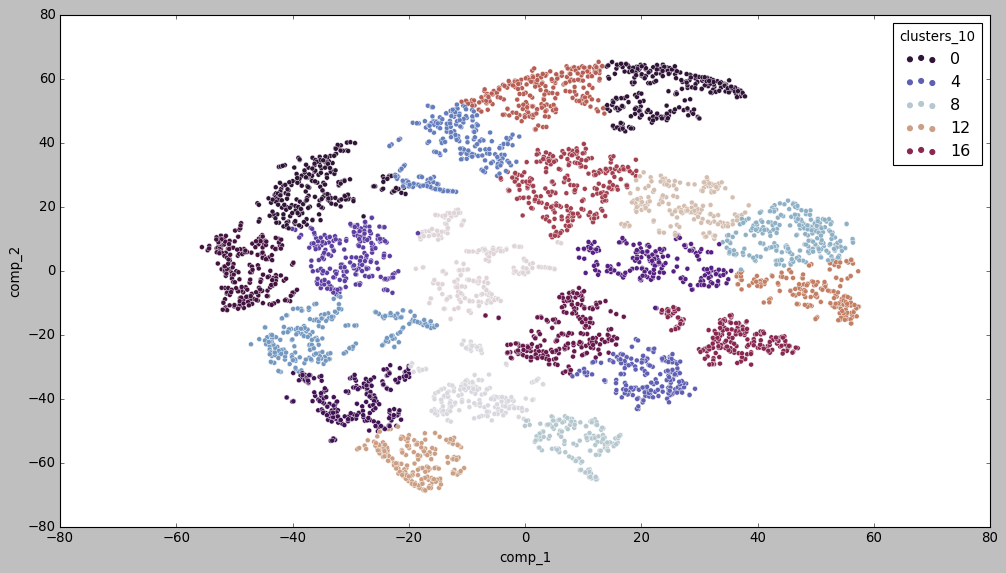

In [615]:
plt.figure(figsize =(15,8))
sns.scatterplot(x ="comp_1", y = "comp_2", data = clusters_v1, hue = "clusters_10", palette = "twilight_shifted")

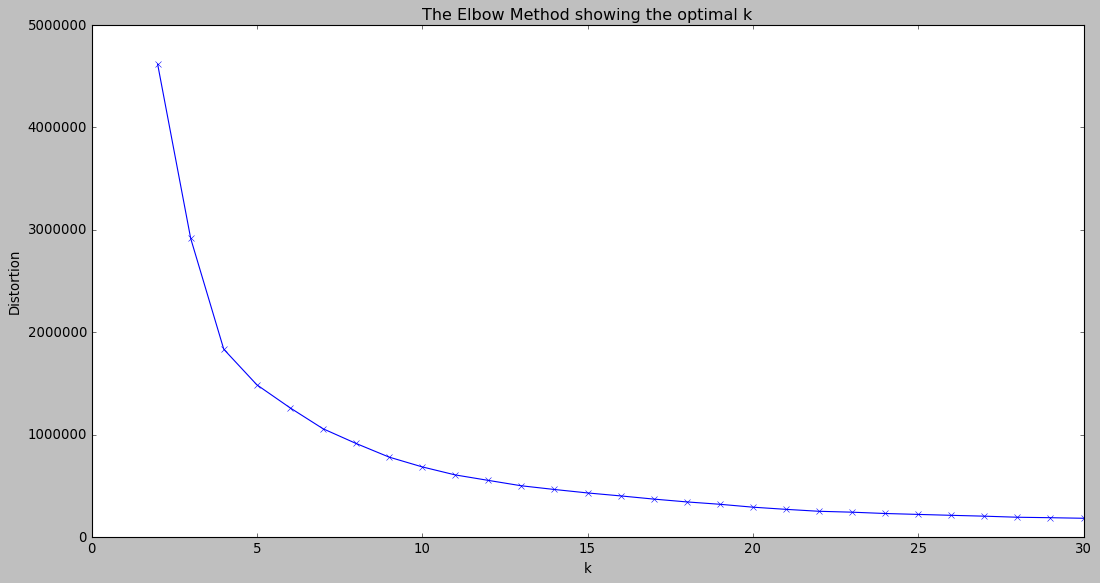

In [616]:
distortions = []
K = range(2,31)
for k in K:
    kmeanModel = KMeans(k)
    kmeanModel.fit(Z[:,:2])
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<AxesSubplot:xlabel='comp_1', ylabel='comp_2'>

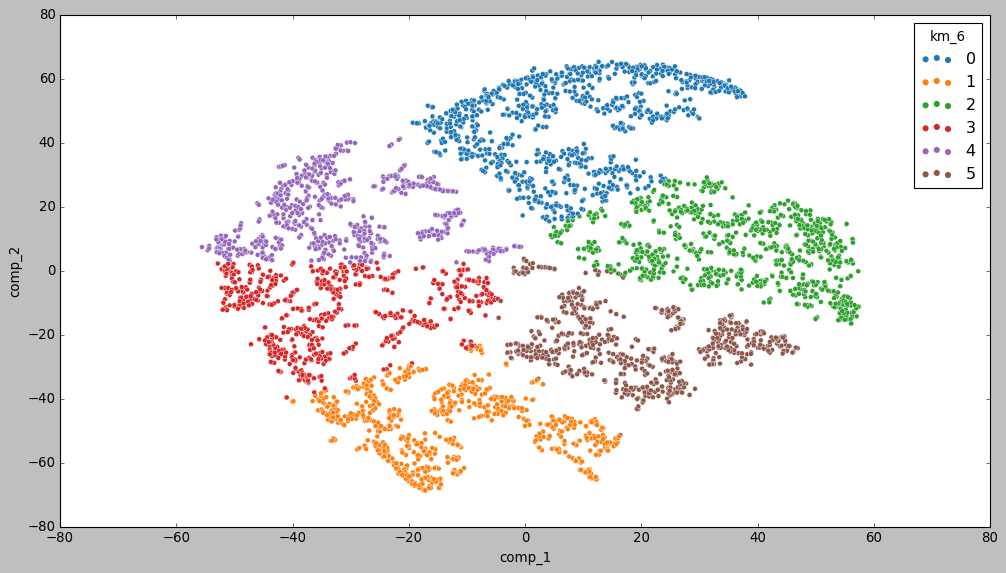

In [617]:
kmeans = KMeans(6)
kmeans.fit(Z[:,:2])
clusters = kmeans.fit_predict(Z[:,:2])

clusters_v2 = pd.concat([pd.DataFrame(Z[:,:2]), pd.DataFrame(clusters)],axis = 1)
clusters_v2.set_axis(['comp_1', 'comp_2', 'km_6'], axis=1, inplace=True)

plt.figure(figsize =(15,8))
sns.scatterplot(x ="comp_1", y = "comp_2", data = clusters_v2, hue = "km_6", palette = "tab10")

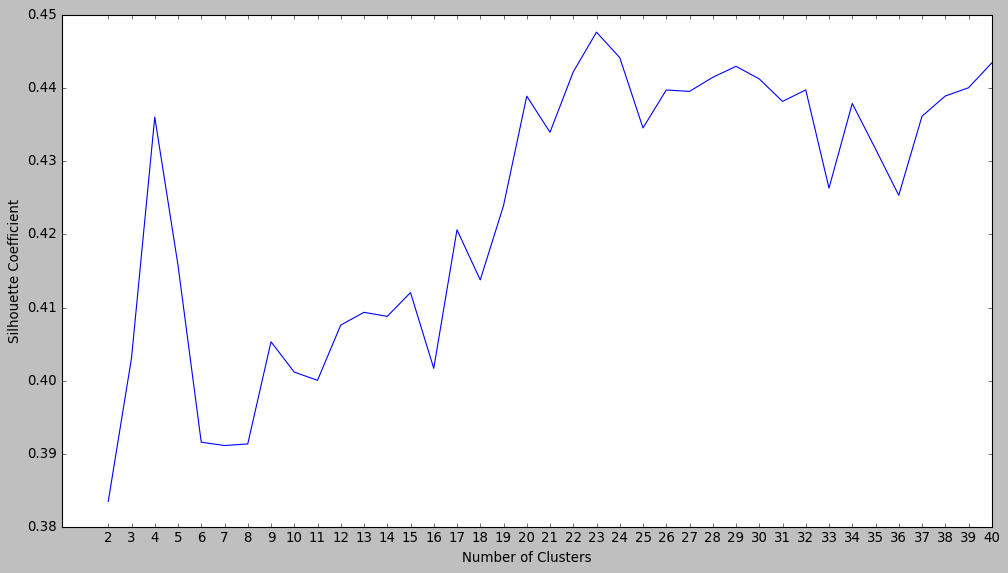

In [618]:
silhouette_coefficients = []

for k in range(2, 41):
    kmeanModel = KMeans(k)
    kmeanModel.fit(Z[:,:2])
    score = silhouette_score(Z[:,:2], kmeanModel.labels_)
    silhouette_coefficients.append(score)

plt.figure(figsize =(15,8))
plt.plot(range(2, 41), silhouette_coefficients)
plt.xticks(range(2, 41))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

<AxesSubplot:xlabel='comp_1', ylabel='comp_2'>

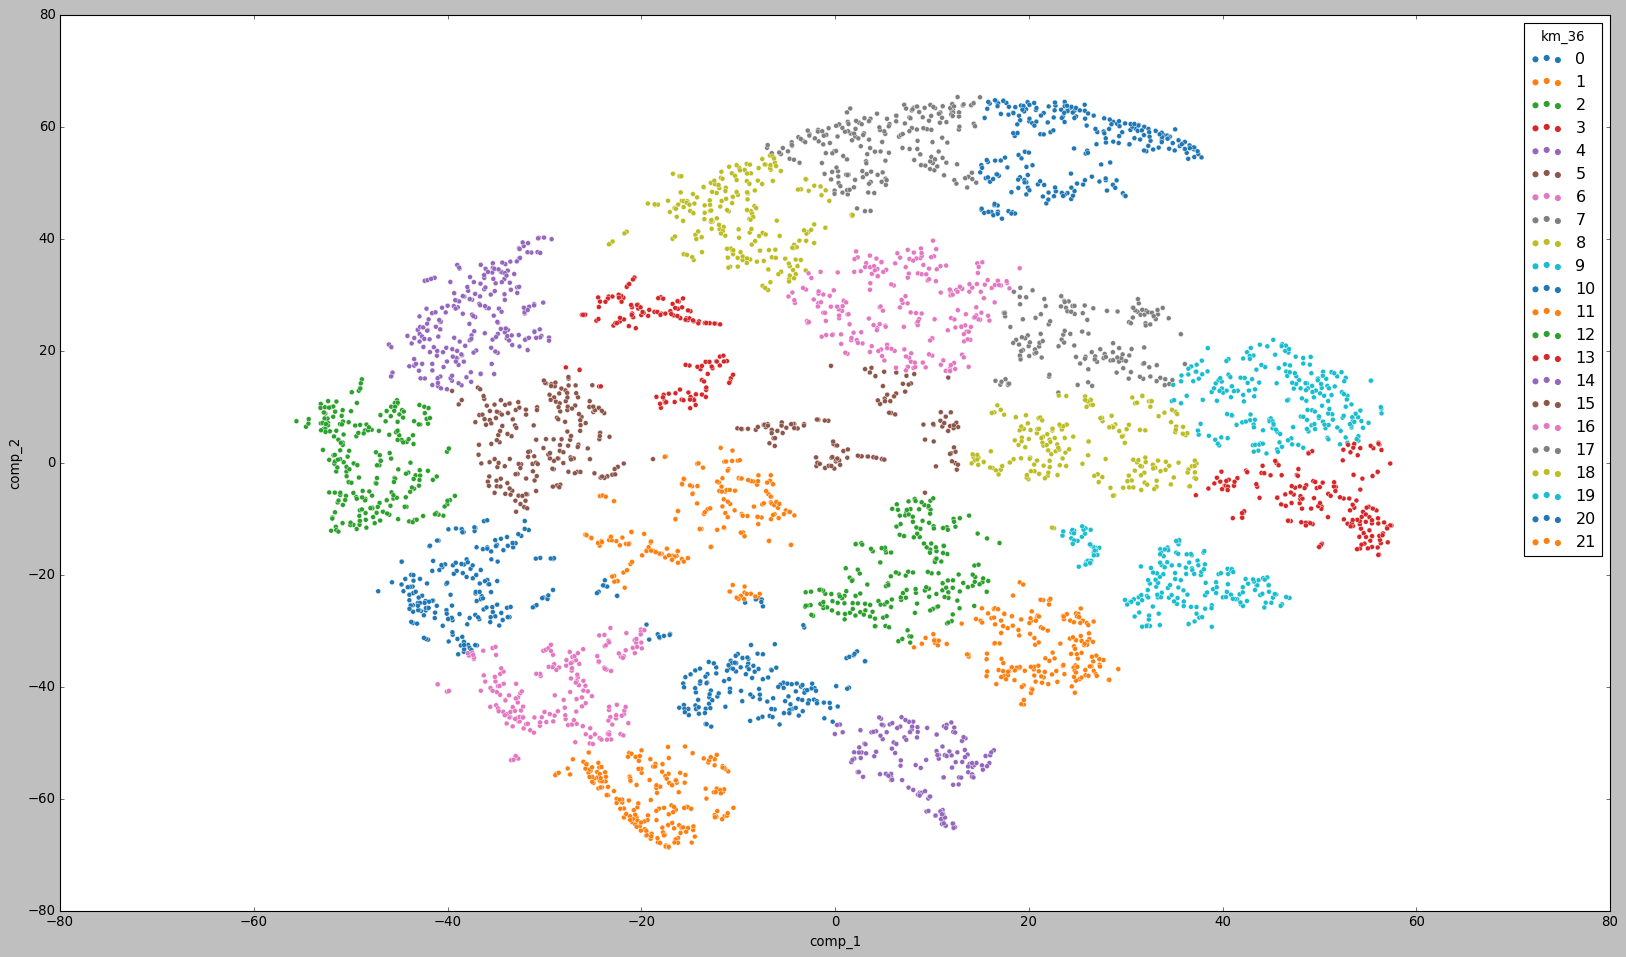

In [619]:
kmeans = KMeans(22)
kmeans.fit(Z[:,:2])
clusters = kmeans.fit_predict(Z[:,:2])

clusters_v2 = pd.concat([pd.DataFrame(Z[:,:2]), pd.DataFrame(clusters)],axis = 1)
clusters_v2.set_axis(['comp_1', 'comp_2', 'km_36'], axis=1, inplace=True)

plt.figure(figsize =(25,14))
sns.scatterplot(x ="comp_1", y = "comp_2", data = clusters_v2, hue = "km_36", palette = "tab10")

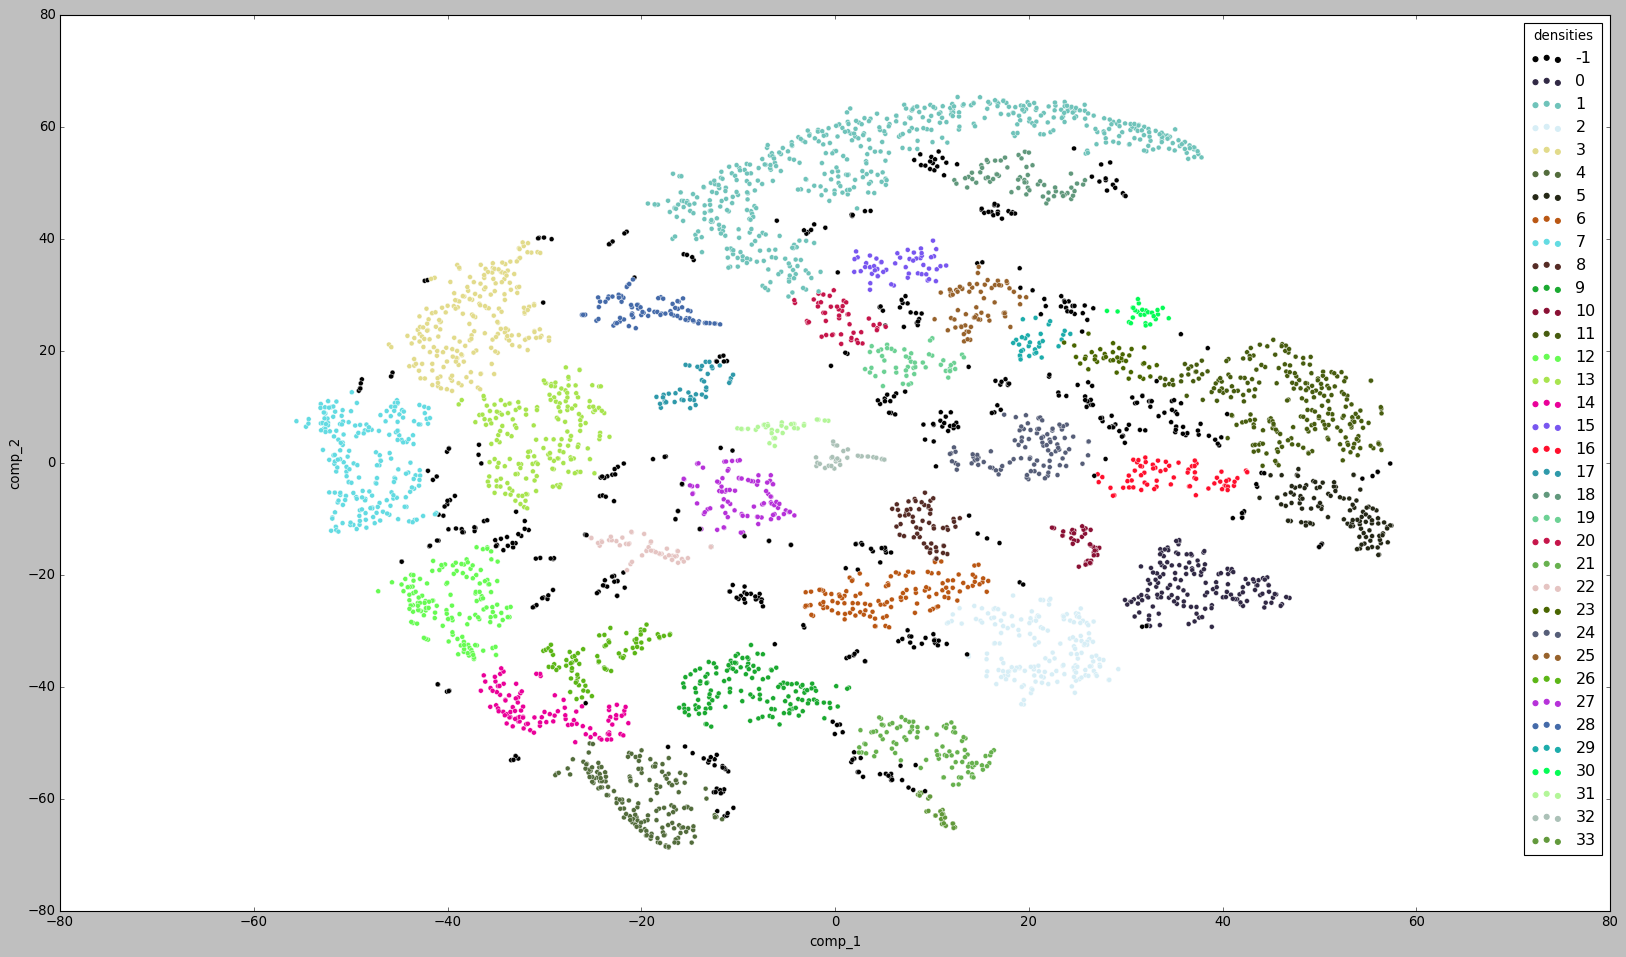

In [628]:
dbscan = DBSCAN(eps=3.5, min_samples=25) 
dbscan.fit(Z[:,:2])
clusters = dbscan.labels_

clusters_v3 = pd.concat([pd.DataFrame(Z[:,:2]), pd.DataFrame(clusters)],axis = 1)
clusters_v3.set_axis(['comp_1', 'comp_2', 'densities'], axis=1, inplace=True)

custom_pallete = {}

for i,x in clusters_v3.iterrows():
    
    color = '#' + '%06x' % random.randint(0, 0xFFFFFF)
    custom_pallete[x[2]] = color 
    
    if x[2] == -1:
        custom_pallete[x[2]] = '#000000'

plt.figure(figsize =(25,14))
sns.scatterplot(x='comp_1', y='comp_2', data=clusters_v3, hue='densities', palette=custom_pallete);

In [653]:
df_v3 = pd.merge(numeric_v2.reset_index(), df[['max_genre', # add columns here
                                               'book_id',
                                               'title',
                                               'description',
                                               'similar_books',
                                               'combined_review',
                                               'popular_shelves', ]].reset_index(), how='left', on=['index'])
df_v3['db_clusters'] = dbscan.labels_

df_v3

,index,average_rating,ratings_count,mystery,fiction,history,fantasy,child,ya,poetry,...,romance,max_genre_numeric,max_genre,book_id,title,description,similar_books,combined_review,popular_shelves,db_clusters
0,0,4.10,651,0,8,0,0,0,7,0,...,0,8,"comics, graphic",17277795,"Ultimate Comics: Spider-Man, by Brian Michael ...",The Daily Bugle is on the hunt to find out eve...,"[13528706, 13276506, 17277786, 17182373, 84819...",Why does everything always have to be so damn ...,"[{'count': '211', 'name': 'to-read'}, {'count'...",-1
1,1,4.03,2663,0,40,2,51,0,5,0,...,0,8,"comics, graphic",7961571,The Amazing Screw-on Head and Other Curious Ob...,Mike Mignola has deservedly become one of the ...,"[7703037, 6660561, 9359546, 690292, 1273012, 7...",Stories in the Mignola style and visuals. As a...,"[{'count': '1433', 'name': 'to-read'}, {'count...",0
2,3,3.30,602,1,5,0,2,1,0,0,...,0,8,"comics, graphic",5626060,"Hulk, Volume 1: Red Hulk",Superstars Jeph Loeb and Ed McGuinness will ch...,"[7935573, 630622, 676739, 18610550, 324949, 15...",Loeb takes a great mystery and turns it in a l...,"[{'count': '228', 'name': 'to-read'}, {'count'...",-1
3,7,4.18,787,2,5,0,17,0,2,0,...,3,8,"comics, graphic",2882715,"Blood+, Vol. 02 (Blood+, #2)","Saya seems, from all appearances, to be an ord...","[6536909, 32001, 6955233, 128524, 3254467, 749...",This volume in particular captures perfectly w...,"[{'count': '236', 'name': 'to-read'}, {'count'...",6
4,9,3.41,162,2,10,17,0,0,0,0,...,0,8,"comics, graphic",6769469,Les Flammes du Bûcher (Borgia #3),"Rome n'est plus une. Ville sainte, mais un cha...","[690975, 190646, 6225010, 174258, 7673712, 140...",Oooh. Incest!\tThe Borgian dynasty is beginnin...,"[{'count': '50', 'name': 'to-read'}, {'count':...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4192,6816,4.11,62,0,1,0,0,0,0,10,...,0,6,poetry,5961725,The Four Seasons (Japanese Haiku Series II),"Step into a series of dazzling, funny, melanch...",[],"Best enjoyed with a cup of coffee, a slow movi...","[{'count': '27', 'name': 'to-read'}, {'count':...",12
4193,6817,4.15,1983,0,11,0,0,0,0,590,...,0,6,poetry,97553,Crow: From the Life and Songs of the Crow,Crowwas Ted Hughes's fourth book of poems for ...,"[201711, 864051, 335140, 472443, 1391333, 4099...","What a horrible lil' dreamscape. Seriously, th...","[{'count': '2480', 'name': 'to-read'}, {'count...",21
4194,6818,3.40,146,0,0,0,0,0,0,10,...,0,6,poetry,20878228,الحب جالس في مقهى الماضي,bmknkm qr@ ldywn 'wn lyn mn khll lrbT ltly\nht...,"[11295329, 16098355, 12805115, 10652846, 11374...",akhr m Sdr l swzn `lywn \n jmyl@ k `dth .. wn ...,"[{'count': '264', 'name': 'to-read'}, {'count'...",1
4195,6819,4.55,1394,0,1,2,0,0,0,7,...,0,6,poetry,230246,دیوان كلیات شمس تبریزی,One of the the greatest works of Persian Liter...,"[1559625, 46292, 1290886, 88268, 254437, 38319...","very good\tBrilliant!if you want to know how ""...","[{'count': '349', 'name': 'to-read'}, {'count'...",2


In [630]:
df_v3[df_v3['db_clusters'] == 12]['max_genre'].value_counts()
# interesting dominated by two categories 
# childrens poems

poetry                                    30
children                                  29
romance                                   17
mystery, thriller, crime                  15
comics, graphic                           12
fantasy, paranormal                       12
non-fiction                               10
history, historical fiction, biography    10
fiction                                   10
young-adult                                4
Name: max_genre, dtype: int64

In [631]:
df_v3[df_v3['db_clusters'] == 12][['title', 'description', 'popular_shelves']].sample(5)

,title,description,popular_shelves
3556,صمت الكليم,,"[{'count': '671', 'name': 'to-read'}, {'count'..."
3339,Murder in Coweta County,"""This is a great book about a great American h...","[{'count': '92', 'name': 'to-read'}, {'count':..."
3671,Questions I Asked My Mother,Winner of the Gerald Lampert Memorial Award (L...,"[{'count': '21', 'name': 'to-read'}, {'count':..."
2318,Facts & Fabrications-Unraveling the History of...,,"[{'count': '34', 'name': 'to-read'}, {'count':..."
4126,Keats: poems published in 1820,Of all the great poets of the early nineteenth...,"[{'count': '121', 'name': 'currently-reading'}..."


In [632]:
df_v3[df_v3['db_clusters'] == 25]['max_genre'].value_counts() # ya, mystery

young-adult                               14
mystery, thriller, crime                  13
fiction                                   10
fantasy, paranormal                        8
romance                                    4
history, historical fiction, biography     4
children                                   3
non-fiction                                3
poetry                                     3
comics, graphic                            2
Name: max_genre, dtype: int64

In [633]:
df_v3[df_v3['db_clusters'] == 1]['max_genre'].value_counts() 

children                                  140
romance                                    72
comics, graphic                            70
mystery, thriller, crime                   48
young-adult                                45
poetry                                     45
fiction                                    37
fantasy, paranormal                        36
history, historical fiction, biography     24
non-fiction                                14
Name: max_genre, dtype: int64

In [634]:
df_v3[df_v3['max_genre'] == 'non-fiction']['db_clusters'].value_counts() 
# on reverse side non_fiction can be seen as outliers to this data set

-1     33
 32    20
 1     14
 9     13
 13    11
 12    10
 3      9
 24     7
 11     7
 6      7
 2      6
 4      6
 7      6
 14     5
 16     5
 19     5
 25     3
 18     3
 30     3
 8      2
 5      2
 20     1
 26     1
Name: db_clusters, dtype: int64

In [635]:
df_v3[df_v3['db_clusters'] == 32]['max_genre'].value_counts() # makes sense! 

non-fiction                               20
history, historical fiction, biography    13
Name: max_genre, dtype: int64

In [636]:
df_v3[df_v3['db_clusters'] == 31]['max_genre'].value_counts()

fiction                                   31
history, historical fiction, biography     6
Name: max_genre, dtype: int64

<AxesSubplot:>

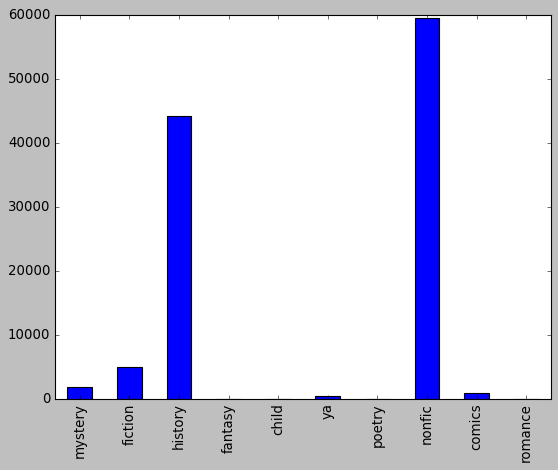

In [644]:
df_v3[df_v3['db_clusters'] == 32][['mystery',                                                                 
'fiction',                                                                 
'history',                                                                 
'fantasy',                                                                 
'child',                                                                  
'ya',                                                                      
'poetry',                                                                  
'nonfic',                                                                  
'comics',                                                                
'romance']].sum().plot.bar()

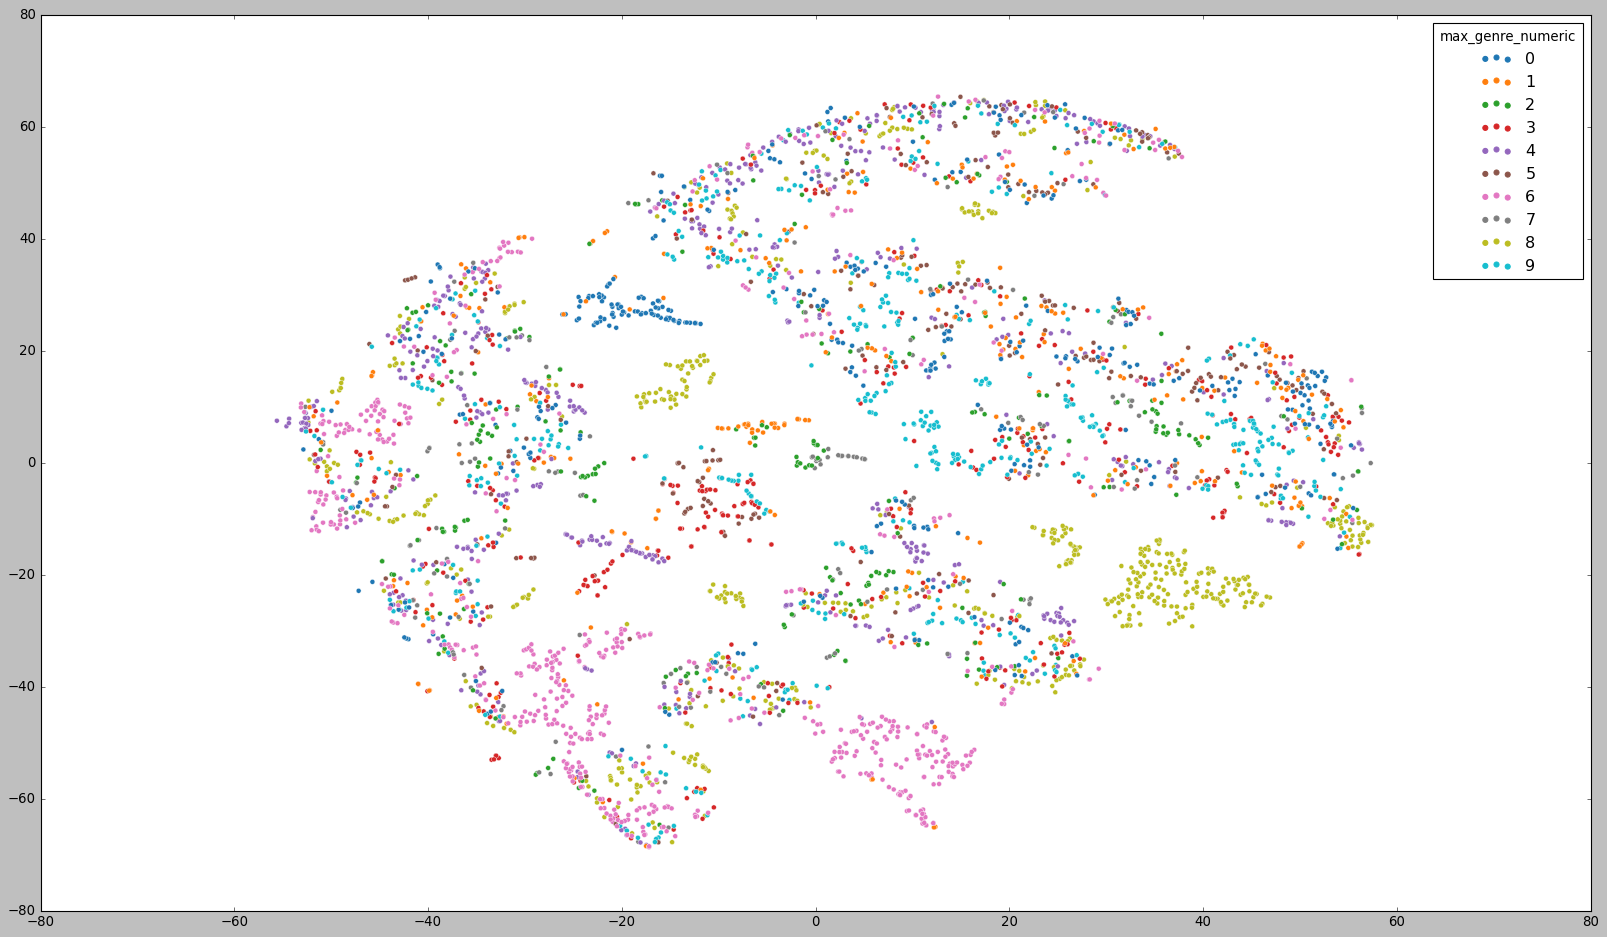

In [682]:
plt.figure(figsize =(25,14))
sns.scatterplot(x=Z[:,0], y=Z[:,1], data=numeric_v2, hue="max_genre_numeric", palette="tab10");

# 0 mystery, thriller, crime
# 1 fiction
# 2 history, historical fiction, biography
# 3 fantasy, paranormal
# 4 children
# 5 young-adult
# 6 poetry
# 7 non-fiction
# 8 comics, graphic
# 9 romance

In [652]:
df_v3.sample(1)

,index,average_rating,ratings_count,mystery,fiction,history,fantasy,child,ya,poetry,...,comics,romance,max_genre_numeric,max_genre,book_id,title,description,similar_books,popular_shelves,db_clusters
114,157,3.94,483,2,5,1,6,0,0,0,...,80,0,8,"comics, graphic",423123,The Big Book of Urban Legends,"/Robert F. Boyd, Jr. This collection of strang...","[423158, 423126, 591110, 423155, 296558, 59111...","[{'count': '390', 'name': 'to-read'}, {'count'...",13


In [662]:
count_vect = CountVectorizer(max_df=0.8, min_df=3, stop_words='english')
doc_term_mat = count_vect.fit_transform(df_v3['combined_review'])

In [665]:
doc_term_mat

<4197x42754 sparse matrix of type '<class 'numpy.int64'>'
	with 1424330 stored elements in Compressed Sparse Row format>

In [670]:
lda = LatentDirichletAllocation(n_components=34, random_state=74)
lda.fit(doc_term_mat)

LatentDirichletAllocation(n_components=34, random_state=74)

In [671]:
for i,topic in enumerate(lda.components_):
    print('Top 15 Words: Topic {}'.format(i))
    print([count_vect.get_feature_names()[index] for index in topic.argsort()[-15:]])
    print('\n\n')

Top 15 Words: Topic 0
['lh', 'hw', 'kn', 'knt', 'ly', 'lty', 'hdh', 'sh', 'kl', 'lktb', 'nh', 'wl', 'lm', 'fy', 'mn']



Top 15 Words: Topic 1
['book', 'tales', 'little', 'chef', 'andersen', 'stories', 'denver', 'restaurant', 'josh', 'lexi', 'eddie', 'story', 'betty', 'gideon', 'adam']



Top 15 Words: Topic 2
['mas', 'para', 'como', 'las', 'pero', 'por', 'una', 'se', 'lo', 'los', 'es', 'el', 'en', 'la', 'que']



Top 15 Words: Topic 3
['good', 'series', 'life', 'characters', 'way', 'know', 'time', 'loved', 'really', 'like', 'read', 'story', 'just', 'love', 'book']



Top 15 Words: Topic 4
['ha', 'piu', 'mi', 'come', 'se', 'da', 'le', 'ma', 'una', 'si', 'non', 'il', 'la', 'che', 'di']



Top 15 Words: Topic 5
['great', 'character', 'comic', 'art', 'book', 'new', 'characters', 'read', 'just', 'good', 'really', 'volume', 'like', 'series', 'story']



Top 15 Words: Topic 6
['dat', 'beautiful', 'day', 'video', 'bullied', 'read', 'boek', 'van', 'en', 'ik', 'een', 'poem', 'book', 'bullying',

In [672]:
topic_results = lda.transform(doc_term_mat)


df_v3['review_topic'] = topic_results.argmax(axis=1)

In [676]:
df_v3[df_v3['db_clusters'] == 0]['review_topic'].value_counts()

5     89
11    11
32     9
12     8
13     8
27     5
21     5
8      4
28     3
20     3
23     2
33     1
17     1
2      1
7      1
14     1
29     1
Name: review_topic, dtype: int64

In [679]:
df_v3[df_v3['review_topic'] == 5]['max_genre'].value_counts()

comics, graphic                           283
mystery, thriller, crime                   41
fantasy, paranormal                        27
fiction                                    24
children                                    7
history, historical fiction, biography      6
young-adult                                 5
poetry                                      3
romance                                     2
Name: max_genre, dtype: int64

In [680]:
df_v3[df_v3['review_topic'] == 9]['max_genre'].value_counts()


children                                  11
fiction                                    3
history, historical fiction, biography     3
young-adult                                2
comics, graphic                            1
non-fiction                                1
fantasy, paranormal                        1
mystery, thriller, crime                   1
Name: max_genre, dtype: int64

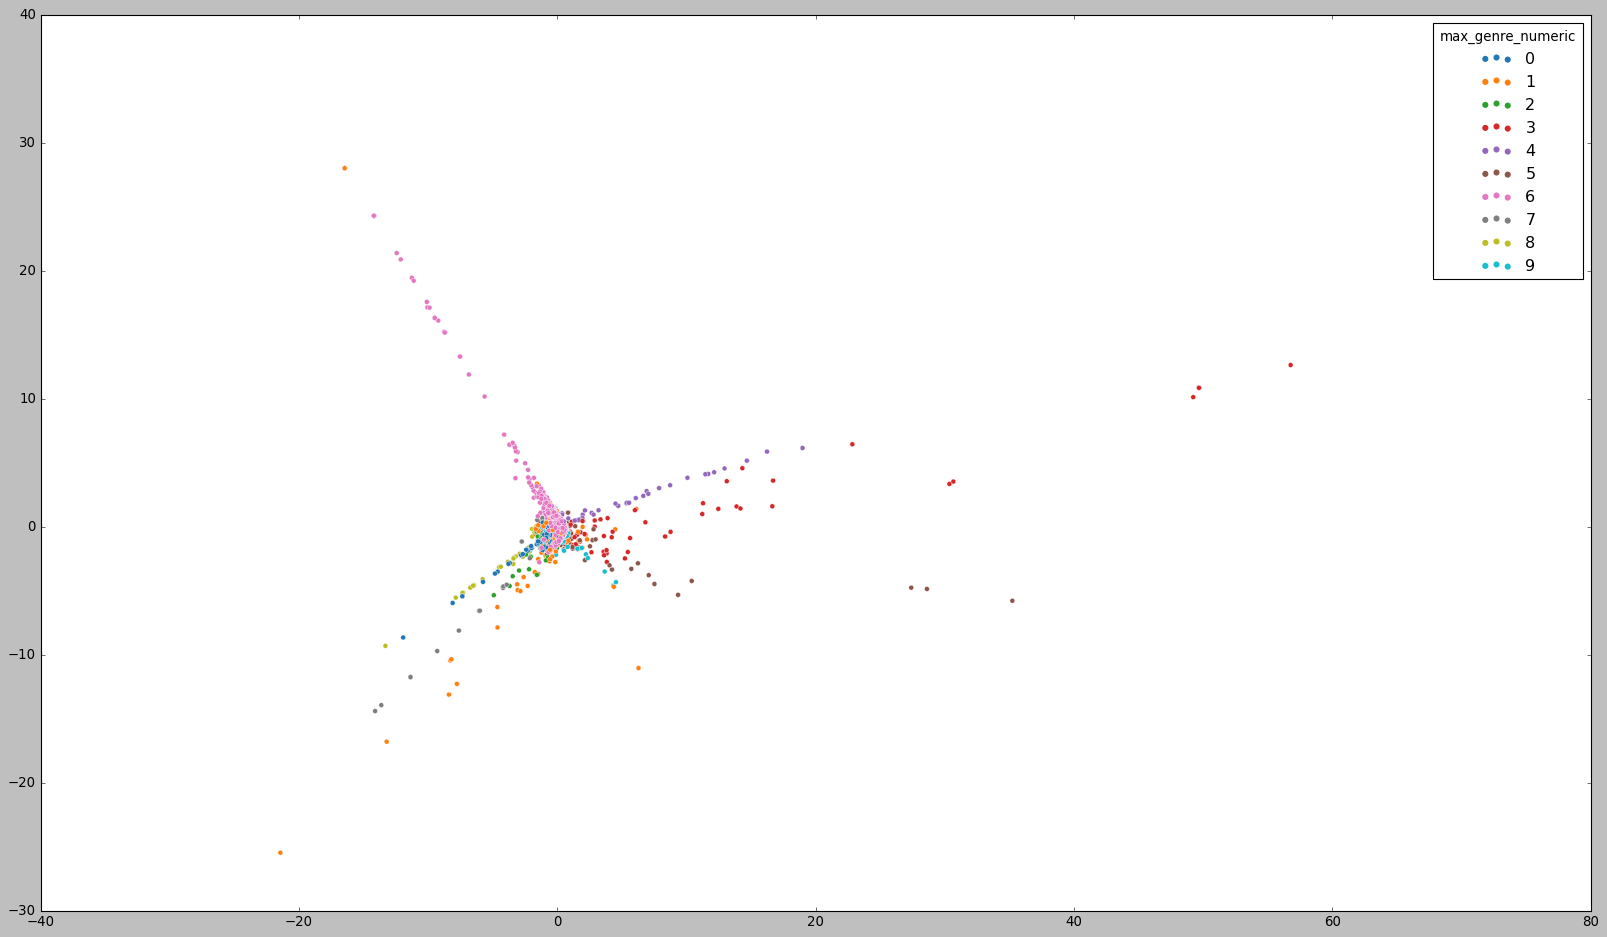

In [689]:
n_neighbors = 5
n_components = 2


isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components) 
Z2 = isomap.fit_transform(scaled_df)

plt.figure(figsize =(25,14))
sns.scatterplot(x=Z2[:,0], y=Z2[:,1], data=numeric_v2, hue="max_genre_numeric", palette="tab10");

In [258]:
reduction[:,0]

array([ 0.21383753, -0.06580698, -0.01786269, ..., -0.18014686,
       -0.04655347, -0.23313254])

In [259]:
reduction[:,1]

array([-0.01656491, -0.00026075, -0.00308007, ..., -0.01081494,
       -0.02021768, -0.0074614 ])

In [325]:
d = defaultdict(str)

In [331]:
for n in ['apple', 'orange', 'grape']:
    d['a'] += n

In [332]:
dict(d)

{'a': 'grapeappleorangegrape'}

In [319]:
d = {'a':1, 'b':'apple'}

lis = []

lis.append([d['a'],d['b']])
lis.append([d['a'],d['b']])
pd.DataFrame(lis)

,0,1
0,1,apple
1,1,apple


In [320]:
load_data_fuzzy()

<function dict.keys>

In [54]:
raw_data.sample(10)

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
3556,1467712345,27,[],US,,"[{'count': '38', 'name': 'to-read'}, {'count':...",,false,3.26,B00SG65DMU,...,4,,2015,https://www.goodreads.com/book/show/19354685-t...,https://images.gr-assets.com/books/1416180554m...,19354685,81,27415839,Trash Mountain,Trash Mountain
4727,0340917555,53,[146020],US,en-GB,"[{'count': '1012', 'name': 'to-read'}, {'count...",,false,3.78,B007LO1KVQ,...,,,2006,https://www.goodreads.com/book/show/124675.The...,https://images.gr-assets.com/books/1415582629m...,124675,3205,120063,"The Secret Seven Adventure (The Secret Seven, #2)","The Secret Seven Adventure (The Secret Seven, #2)"
335,0750013931,3,[381005],US,,"[{'count': '224', 'name': 'to-read'}, {'count'...",,false,4.23,,...,,,,https://www.goodreads.com/book/show/1914630.Th...,https://s.gr-assets.com/assets/nophoto/book/11...,1914630,41,80619,"The Oaken Throne (The Deptford Histories, #2)","The Oaken Throne (The Deptford Histories, #2)"
584,0823424006,25,[],US,,"[{'count': '23', 'name': 'to-read'}, {'count':...",,false,3.47,,...,2,,2012,https://www.goodreads.com/book/show/12710065-f...,https://images.gr-assets.com/books/1328019578m...,12710065,87,17843561,Fox Tails: Four Fables from Aesop,Fox Tails: Four Fables from Aesop
8990,9953875367,3,[],US,ara,"[{'count': '2505', 'name': 'to-read'}, {'count...",,false,3.90,,...,,,2008,https://www.goodreads.com/book/show/8082219,https://s.gr-assets.com/assets/nophoto/book/11...,8082219,6,1021311,عفريت الأرقام,عفريت الأرقام
9120,1612440916,6,[],US,en-US,"[{'count': '187', 'name': 'to-read'}, {'count'...",,false,4.17,B008AK7ALE,...,8,,2012,https://www.goodreads.com/book/show/15831747-v...,https://images.gr-assets.com/books/1367002342m...,15831747,13,21373662,Vin and the Dorky Duet,Vin and the Dorky Duet
8751,,3,[155079],US,eng,"[{'count': '89', 'name': 'to-read'}, {'count':...",,false,3.96,B00GVFU7R4,...,,,2009,https://www.goodreads.com/book/show/1137256.Ca...,https://images.gr-assets.com/books/1338051257m...,1137256,14,1124501,"Caddy Ever After (Casson Family, #4)","Caddy Ever After (Casson Family, #4)"
5684,8877828226,2,[206569],US,ita,"[{'count': '216', 'name': 'to-read'}, {'count'...",,false,3.95,,...,1,Brutte Storie,1999,https://www.goodreads.com/book/show/9749359-i-...,https://images.gr-assets.com/books/1445556344m...,9749359,15,413020,I cinici celti,I cinici celti
5131,,1,[],US,,"[{'count': '568', 'name': 'to-read'}, {'count'...",B00JMV8TAG,true,4.05,B00JMV8TAG,...,,,,https://www.goodreads.com/book/show/22930358-a...,https://s.gr-assets.com/assets/nophoto/book/11...,22930358,13,3719102,AN OLD-FASHIONED GIRL. (Annotated) (Louisa May...,AN OLD-FASHIONED GIRL. (Annotated) (Louisa May...
6135,,1,[],US,,"[{'count': '976', 'name': 'to-read'}, {'count'...",,false,3.89,,...,,,,https://www.goodreads.com/book/show/26217381-g...,https://images.gr-assets.com/books/1441263911m...,26217381,23,2801485,Gümüş Patenler,Gümüş Patenler


In [9]:
raw_data.columns

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series'],
      dtype='object')

In [33]:
# popular shelves - top user generated shelves for a book, defines genres 
raw_data['popular_shelves'][96]

[{'count': '7173', 'name': 'to-read'},
 {'count': '235', 'name': 'vampires'},
 {'count': '195', 'name': 'currently-reading'},
 {'count': '194', 'name': 'young-adult'},
 {'count': '186', 'name': 'favorites'},
 {'count': '109', 'name': 'fantasy'},
 {'count': '104', 'name': 'vampire'},
 {'count': '81', 'name': 'owned'},
 {'count': '80', 'name': 'books-i-own'},
 {'count': '77', 'name': 'ya'},
 {'count': '76', 'name': 'series'},
 {'count': '73', 'name': 'paranormal'},
 {'count': '50', 'name': 'supernatural'},
 {'count': '42', 'name': 'heather-brewer'},
 {'count': '41', 'name': 'fiction'},
 {'count': '37', 'name': 'horror'},
 {'count': '31', 'name': 'teen'},
 {'count': '31', 'name': 'urban-fantasy'},
 {'count': '30', 'name': 'the-chronicles-of-vladimir-tod'},
 {'count': '30', 'name': 'vladimir-tod'},
 {'count': '21', 'name': 'romance'},
 {'count': '21', 'name': 'library'},
 {'count': '18', 'name': 'owned-books'},
 {'count': '18', 'name': 'to-buy'},
 {'count': '16', 'name': 'high-school'},
 {

In [32]:
display(raw_data['similar_books'][96]) # list of books that users who like the current book also like

display(raw_data.iloc[96,:])

['25861113',
 '7430195',
 '18765937',
 '6120544',
 '3247550',
 '9266753',
 '6976966',
 '25764778',
 '17696585',
 '23256849',
 '642463',
 '2842796',
 '263172',
 '10874337']

isbn                                                                     
text_reviews_count                                                      9
series                                                           [176160]
country_code                                                           US
language_code                                                         eng
popular_shelves         [{'count': '7173', 'name': 'to-read'}, {'count...
asin                                                           B0042JSOQC
is_ebook                                                             true
average_rating                                                       4.35
kindle_asin                                                    B004IYJDXY
similar_books           [25861113, 7430195, 18765937, 6120544, 3247550...
description             It all comes down to this.\nVlad's running out...
format                                                                   
link                    https://www.go

### Checks for 'similar_books' 

Are they book ids? or ISBNs?

In [25]:
raw_data[raw_data['book_id'] == 7430195]

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series


In [40]:
mask = raw_data.isbn.apply(lambda x: '25861113' == x) # 
raw_data[mask] 

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series


In [41]:
# check entire dataset for similar books